In [ ]:
import pandas as pd

# Loading the dataset
df_tree = pd.read_csv("forestCover.csv")
print(df_tree.shape)
df_tree.head()


(581012, 59)


,Elevation,Aspect,Facet,Slope,Inclination,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,...,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Water_Level,Observation_ID,Cover_Type
0,3208920,166,415.394727,6,0.691628,408,62,3137,225,242,...,0,0,0,0,0,0,0,2,1,2
1,2789020,137,343.302186,9,0.621245,30,2,1040,235,237,...,0,0,0,0,0,0,0,3,1,3
2,3384615,357,894.231390,9,-0.266086,362,15,3113,207,225,...,0,0,0,0,0,0,0,4,1,1
3,3348150,148,371.346939,6,0.786375,247,50,1207,228,240,...,0,0,0,0,0,0,0,5,1,2
4,3061955,124,310.783430,11,-0.335685,170,19,1595,238,232,...,0,0,0,0,0,0,0,6,1,2


In [ ]:
# Dropping both Observation_ID (identifier) and Water_Level (constant)
df_tree.drop(columns=['Observation_ID', 'Water_Level'], inplace=True)


In [ ]:
# Facet is highly correlated with Aspect so dropping it
df_tree.drop(columns=['Facet'], inplace=True)


In [ ]:
# Inclination contains only noisy values, so dropping
df_tree.drop(columns=['Inclination'], inplace=True)


In [ ]:
# fixing soil type issue 
df_tree['Soil_Type1'] = df_tree['Soil_Type1'].map({'positive': 1, 'negative': 0}).astype(int)


In [ ]:
# fixing missing values issue
df_tree = df_tree.replace('?', pd.NA)
df_tree = df_tree.apply(pd.to_numeric, errors='ignore')

# Imputing missing values in Slope with median
df_tree['Slope'] = df_tree['Slope'].fillna(df_tree['Slope'].median())


/tmp/ipykernel_3891/305979018.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_tree = df_tree.apply(pd.to_numeric, errors='ignore')


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier

X_full = df_tree.drop(columns=['Cover_Type'])
y_full = df_tree['Cover_Type']

# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, 
    test_size=0.2,
    random_state=42,
    stratify=y_full
)

# Sampling 20% of training data 
X_train_sample = X_train.sample(frac=0.2, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

print(f"Baseline DT evaluation on {X_train_sample.shape[0]} samples")

# the baseline Decision Tree model (class weight addresses skewed imbalance issue)
dt_baseline = DecisionTreeClassifier(random_state=42, class_weight="balanced")

# Stratified 5-fold CV 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(dt_baseline, X_train_sample, y_train_sample, cv=cv, scoring='accuracy')

print(f"Baseline Decision Tree Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Baseline DT evaluation on 92962 samples
Baseline Decision Tree Accuracy: 0.8513 ± 0.0022


Full training: 464809 samples
Sampled training: 92962 samples
Test set: 116203 samples
Running Decision Tree Grid Search with 5-fold CV...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.6s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.6s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.6s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.7s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.7s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.6s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=

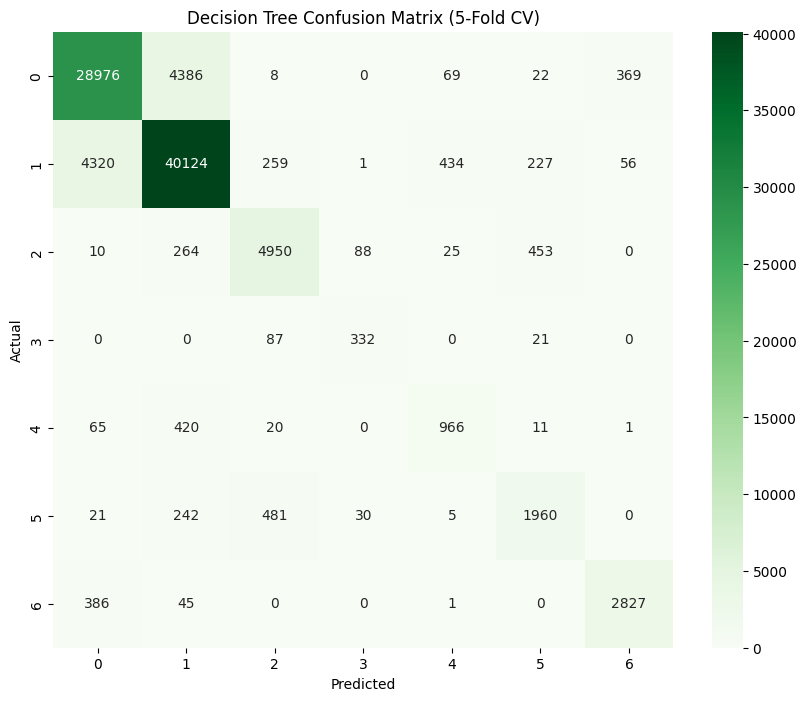


Confusion Matrix:
[[28976  4386     8     0    69    22   369]
 [ 4320 40124   259     1   434   227    56]
 [   10   264  4950    88    25   453     0]
 [    0     0    87   332     0    21     0]
 [   65   420    20     0   966    11     1]
 [   21   242   481    30     5  1960     0]
 [  386    45     0     0     1     0  2827]]

Held-out Test Set Accuracy: 0.8741


In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# hyperparameter tuning model
X_full = df_tree.drop(columns=['Cover_Type'])
y_full = df_tree['Cover_Type']

# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, 
    test_size=0.2,
    random_state=42,
    stratify=y_full
)

# Sampling 20% of training data
X_train_sample = X_train.sample(frac=0.2, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

print(f"Full training: {X_train.shape[0]} samples")
print(f"Sampled training: {X_train_sample.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# the parameter grid for Decision Tree
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)

# Grid search on sampled training data
print("Running Decision Tree Grid Search with 5-fold CV...")
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_search.fit(X_train_sample, y_train_sample)
print("Best Params:", grid_search.best_params_)

# Getting training and test scores
best_index = grid_search.best_index_
train_score = grid_search.cv_results_['mean_train_score'][best_index]
test_score = grid_search.best_score_

print(f"Training Accuracy: {train_score:.4f}")
print(f"Test Accuracy (CV): {test_score:.4f}")

# Getting the best model
best_dt = grid_search.best_estimator_

# Cross-validation scores with mean and std
cv_scores = cross_val_score(best_dt, X_train_sample, y_train_sample, cv=cv, scoring='accuracy')
print(f"\n5-Fold CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Individual fold scores: {cv_scores}")

# F1 scores
f1_scores = cross_val_score(best_dt, X_train_sample, y_train_sample, cv=cv, scoring='f1_macro')
print(f"5-Fold CV F1-Macro: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")

# Getting the predictions for confusion matrix
y_pred_cv = cross_val_predict(best_dt, X_train_sample, y_train_sample, cv=cv)

# Detailed results
print("\nClassification Report (5-fold CV):")
print(classification_report(y_train_sample, y_pred_cv))

macro_f1 = f1_score(y_train_sample, y_pred_cv, average='macro')
weighted_f1 = f1_score(y_train_sample, y_pred_cv, average='weighted')
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_train_sample, y_pred_cv)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Decision Tree Confusion Matrix (5-Fold CV)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nConfusion Matrix:")
print(cm)

# Testing on held-out test set
test_pred = best_dt.predict(X_test)
test_accuracy = best_dt.score(X_test, y_test)
print(f"\nHeld-out Test Set Accuracy: {test_accuracy:.4f}")

In [22]:
# using grid searches now to be more precise
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Sample for tuning
df_sample = df_tree.sample(300000, random_state=42)
X_sample = df_sample.drop(columns=['Cover_Type'])
y_sample = df_sample['Cover_Type']

X_full = df_tree.drop(columns=['Cover_Type'])
y_full = df_tree['Cover_Type']

# 5-fold for tuning, 10-fold for final
tune_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
final_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Parameter grid for tuning
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=tune_cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Run tuning on sample
grid_search.fit(X_sample, y_sample)

print("Best Params:", grid_search.best_params_)
print(f"Tuned Accuracy (sample, 5-fold): {grid_search.best_score_:.4f}")

# Validate best model on full data with 10-fold
best_dt = grid_search.best_estimator_
scores_final = cross_val_score(best_dt, X_full, y_full, cv=final_cv, scoring='accuracy', n_jobs=-1)
print(f"Final 10-fold Accuracy: {scores_final.mean():.4f} ± {scores_final.std():.4f}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   3.7s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   3.8s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   3.8s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   3.8s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   3.9s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   3.9s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   3.9s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   4.0s

In [24]:
from sklearn.calibration import cross_val_predict
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score

# Sample for tuning
df_sample = df_tree.sample(20000, random_state=42)
X_sample = df_sample.drop(columns=['Cover_Type'])
y_sample = df_sample['Cover_Type']

# Full dataset for final evaluation
X_full = df_tree.drop(columns=['Cover_Type'])
y_full = df_tree['Cover_Type']

# CV splits
tune_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
final_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Parameter grid for tuning
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# Decision Tree with class_weight for imbalance
dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")

# Grid search for tuning (using accuracy)
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=tune_cv,
    scoring='accuracy',   # you can change to 'f1_macro' if you want fairness
    n_jobs=-1,
    verbose=2
)

# Run tuning on sample
grid_search.fit(X_sample, y_sample)

print("Best Params:", grid_search.best_params_)
print(f"Tuned Accuracy (sample, 5-fold): {grid_search.best_score_:.4f}")

# Validate best model on full data (10-fold)
best_dt = grid_search.best_estimator_
scores_final = cross_val_score(best_dt, X_full, y_full, cv=final_cv, scoring='accuracy', n_jobs=-1)
print(f"Final 10-fold Accuracy: {scores_final.mean():.4f} ± {scores_final.std():.4f}")

# --- NEW PART: Minority class performance ---
# Cross-validated predictions on full data
y_pred_cv = cross_val_predict(best_dt, X_full, y_full, cv=final_cv, n_jobs=-1)

print("\nClassification Report (10-fold CV):")
print(classification_report(y_full, y_pred_cv))

# Compute macro and weighted F1 with CV predictions
macro_f1 = f1_score(y_full, y_pred_cv, average='macro')
weighted_f1 = f1_score(y_full, y_pred_cv, average='weighted')
print(f"Macro F1 Score (CV): {macro_f1:.4f}")
print(f"Weighted F1 Score (CV): {weighted_f1:.4f}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.1s

In [ ]:
# now doing hyperparameter tuning on the whole dataset
from sklearn.calibration import cross_val_predict
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score

# Full dataset
X_full = df_tree.drop(columns=['Cover_Type'])
y_full = df_tree['Cover_Type']

# CV splits
tune_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
final_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Parameter grid for tuning
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# Decision Tree with class_weight for imbalance
dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")

# Grid search for tuning on full data
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=tune_cv,
    scoring='accuracy',  # or 'f1_macro' for fairness
    n_jobs=-1,
    verbose=2
)

# Fit grid search on full data
grid_search.fit(X_full, y_full)

print("Best Params:", grid_search.best_params_)
print(f"Tuned Accuracy (full data, 5-fold): {grid_search.best_score_:.4f}")

# Validate best model on full data (10-fold)
best_dt = grid_search.best_estimator_
scores_final = cross_val_score(best_dt, X_full, y_full, cv=final_cv, scoring='accuracy', n_jobs=-1)
print(f"Final 10-fold Accuracy: {scores_final.mean():.4f} ± {scores_final.std():.4f}")

# Minority class performance
y_pred_cv = cross_val_predict(best_dt, X_full, y_full, cv=final_cv, n_jobs=-1)

print("\nClassification Report (10-fold CV):")
print(classification_report(y_full, y_pred_cv))

macro_f1 = f1_score(y_full, y_pred_cv, average='macro')
weighted_f1 = f1_score(y_full, y_pred_cv, average='weighted')
print(f"Macro F1 Score (CV): {macro_f1:.4f}")
print(f"Weighted F1 Score (CV): {weighted_f1:.4f}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   8.9s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   8.9s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   9.1s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   9.5s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   9.6s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   9.7s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   9.8s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   9.9

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   6.6s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2; total time=   6.8s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2; total time=   6.9s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   6.8s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   6.9s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   6.9s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   6.9s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   7.1s

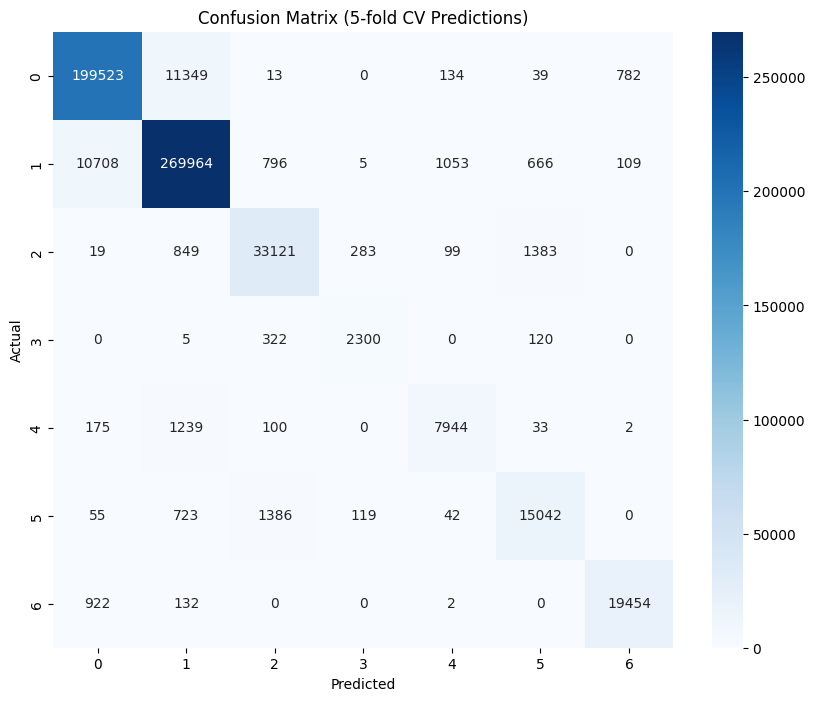

In [13]:
# now doing hyperparameter tuning on the whole dataset
from sklearn.calibration import cross_val_predict
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Full dataset
X_full = df_tree.drop(columns=['Cover_Type'])
y_full = df_tree['Cover_Type']

# CV splits
tune_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
final_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Parameter grid for tuning
param_grid = {
    'max_depth': [5, 10, 15,None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1,2,4],
    'max_features': [ None,'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# Decision Tree with class_weight for imbalance
dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")

# Grid search for tuning on full data
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=tune_cv,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=2
)

# Fit grid search on full data
grid_search.fit(X_full, y_full)

print("Best Params:", grid_search.best_params_)
print(f"Tuned Accuracy (full data, 3-fold): {grid_search.best_score_:.4f}")

# Validate best model on full data (5-fold)
best_dt = grid_search.best_estimator_
scores_final = cross_val_score(best_dt, X_full, y_full, cv=final_cv, scoring='accuracy', n_jobs=-1)
print(f"Final 5-fold Accuracy: {scores_final.mean():.4f} ± {scores_final.std():.4f}")

# Minority class performance
y_pred_cv = cross_val_predict(best_dt, X_full, y_full, cv=final_cv, n_jobs=-1)

print("\nClassification Report (5-fold CV):")
print(classification_report(y_full, y_pred_cv))

macro_f1 = f1_score(y_full, y_pred_cv, average='macro')
weighted_f1 = f1_score(y_full, y_pred_cv, average='weighted')
print(f"Macro F1 Score (CV): {macro_f1:.4f}")
print(f"Weighted F1 Score (CV): {weighted_f1:.4f}")

# 80/20 split with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Fit best model on training set
best_dt.fit(X_train, y_train)

# Compute training accuracy (on 80% training data)
train_preds = best_dt.predict(X_train)
training_accuracy = (train_preds == y_train).mean()
print(f"Training Accuracy (80% train): {training_accuracy:.4f}")

# Compute hold-out test accuracy (on 20% unseen data)
test_preds = best_dt.predict(X_test)
test_accuracy = (test_preds == y_test).mean()
print(f"Test Accuracy (20% test): {test_accuracy:.4f}")


# Confusion matrix for CV predictions
cm = confusion_matrix(y_full, y_pred_cv)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (5-fold CV Predictions)')
plt.show()



Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.3s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.4s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.4s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.4s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.4s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.4s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.4s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.5s

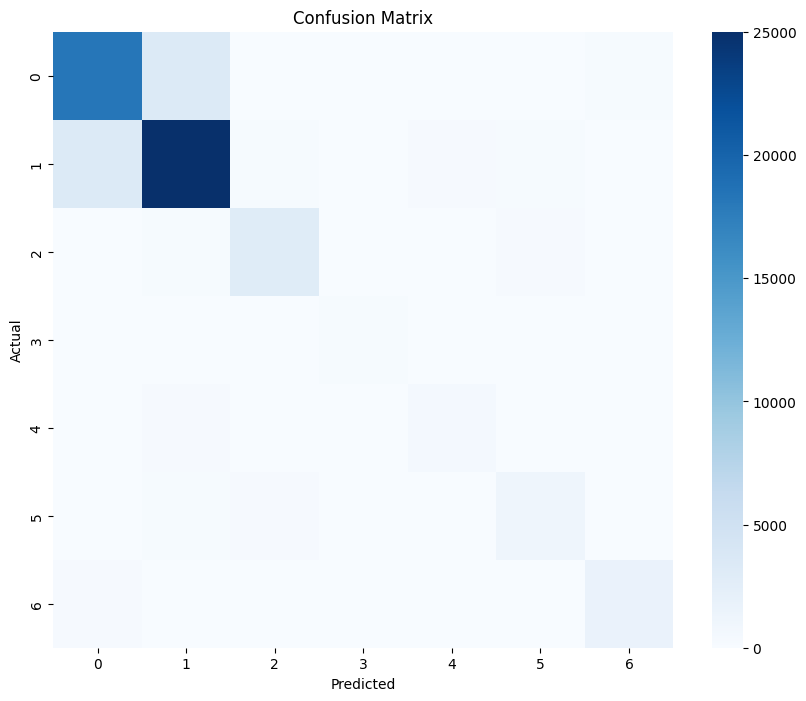

In [ ]:
# decision tree with CV + hold-out evaluation (sampled train set for speed)

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, cross_val_predict, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Split dataset first ---
X_full = df_tree.drop(columns=['Cover_Type'])
y_full = df_tree['Cover_Type']

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# --- 2. Sample from train set for feasibility (stratified) ---
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train,
    train_size=60000,
    stratify=y_train,
    random_state=42
)

# --- 3. Hyperparameter tuning with CV on sampled train set ---
tune_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    param_grid=param_grid,
    cv=tune_cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_sample, y_train_sample)
print("Best Params:", grid_search.best_params_)

# Mean ± std CV accuracy on train sample
cv_scores = cross_val_score(
    grid_search.best_estimator_, X_train_sample, y_train_sample,
    cv=tune_cv, scoring='accuracy', n_jobs=-1
)
print(f"Tuned Accuracy (5-fold CV on train sample): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# --- 4. CV predictions for F1 + classification report (on sample) ---
best_knn = grid_search.best_estimator_
y_pred_cv = cross_val_predict(best_knn, X_train_sample, y_train_sample, cv=tune_cv, n_jobs=-1)

print("\nClassification Report (5-fold CV on train sample):")
print(classification_report(y_train_sample, y_pred_cv))

macro_f1 = f1_score(y_train_sample, y_pred_cv, average='macro')
weighted_f1 = f1_score(y_train_sample, y_pred_cv, average='weighted')
print(f"Macro F1 (CV): {macro_f1:.4f}")
print(f"Weighted F1 (CV): {weighted_f1:.4f}")

# --- 5. Train best model on full training set (not sample) ---
best_knn.fit(X_train, y_train)

# Training accuracy
train_preds = best_knn.predict(X_train)
training_accuracy = (train_preds == y_train).mean()
print(f"\nTraining Accuracy (80% train): {training_accuracy:.4f}")

# --- 6. Evaluate on hold-out test set (20%) ---
test_preds = best_knn.predict(X_test)
test_accuracy = (test_preds == y_test).mean()
print(f"Test Accuracy (20% test): {test_accuracy:.4f}")



# Confusion matrix for test set
cm = confusion_matrix(y_train_sample, y_pred_cv)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

=== DEBUGGING INFO ===
Original dataset size: 581012
Train set size: 464809
Train sample size: 60000
Test set size: 116203
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Params: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Tuned Accuracy (5-fold CV on train sample): 0.8303 ± 0.0035

Classification Report (5-fold CV on train sample):
              precision    recall  f1-score   support

           1       0.83      0.83      0.83     21876
           2       0.86      0.86      0.86     29256
           3       0.80      0.80      0.80      3692
           4       0.72      0.71      0.72       284
           5       0.60      0.58      0.59       980
           6       0.64      0.64      0.64      1794
           7       0.85      0.82      0.83      2118

    accuracy                           0.83     60000
   macro avg       0.76      0.75      0.75     60000
weighted avg       0.83      0.83

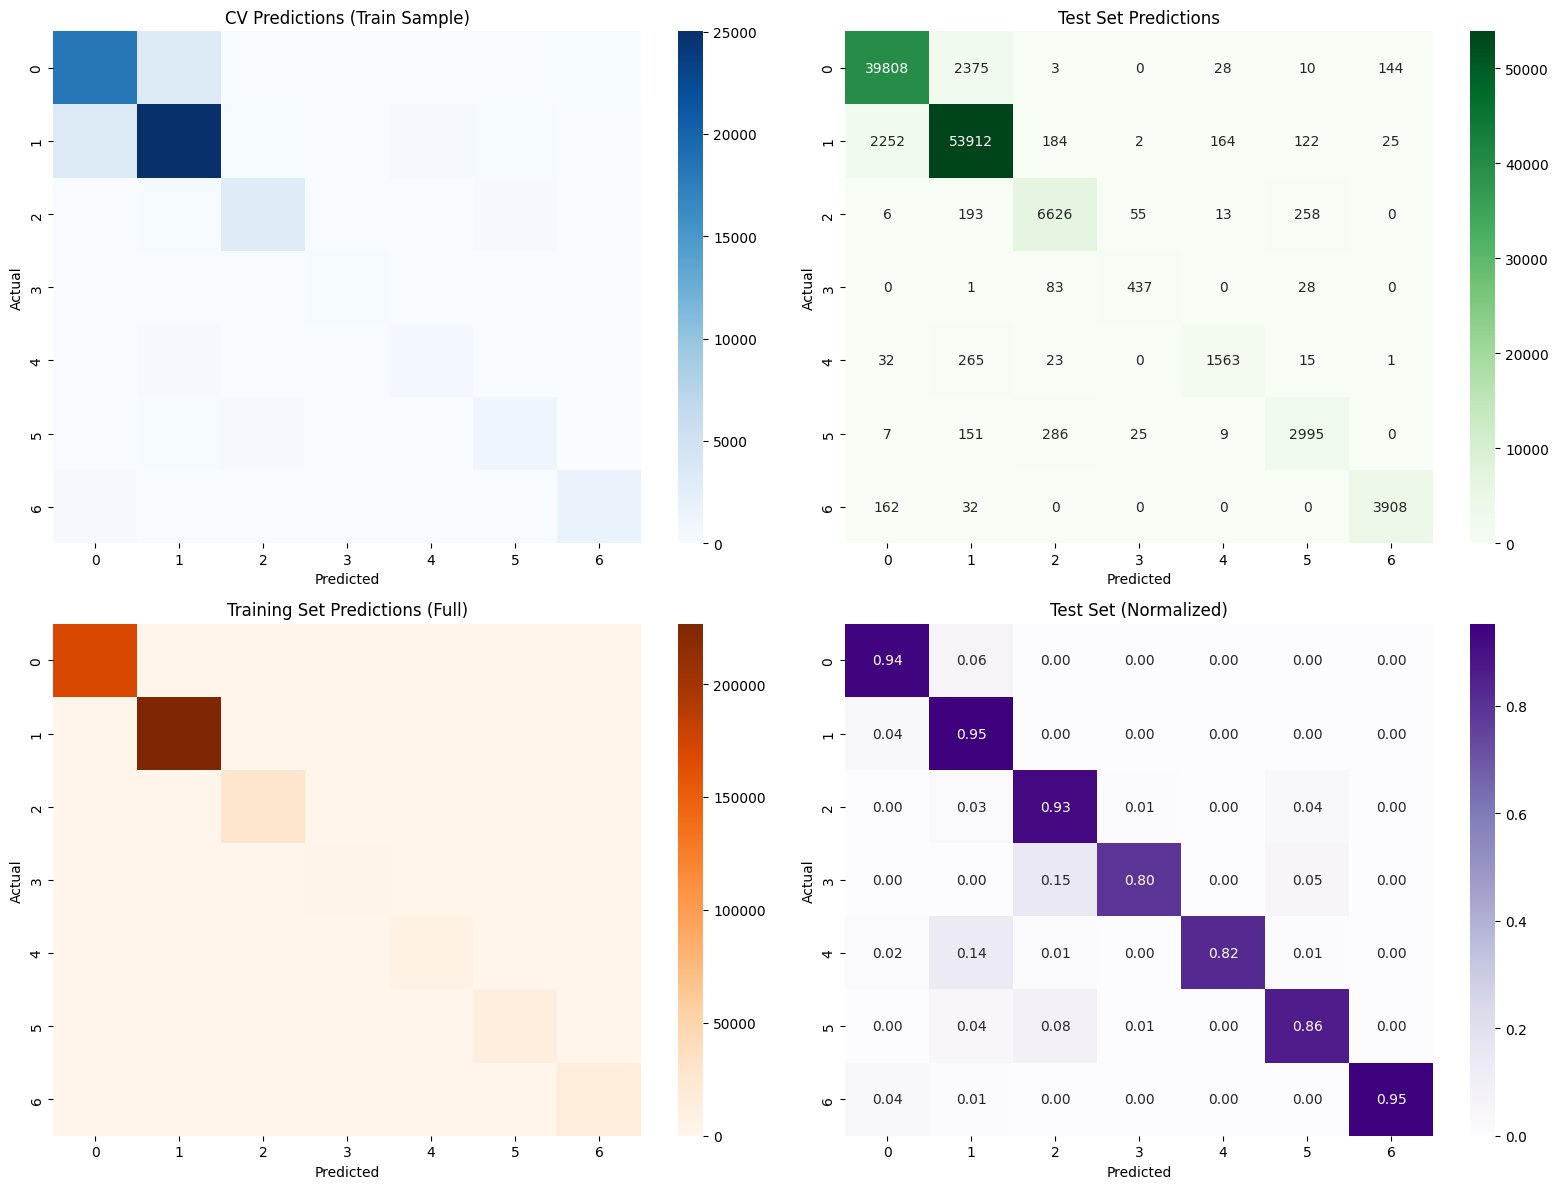


=== TRYING SIMPLE MATPLOTLIB ===


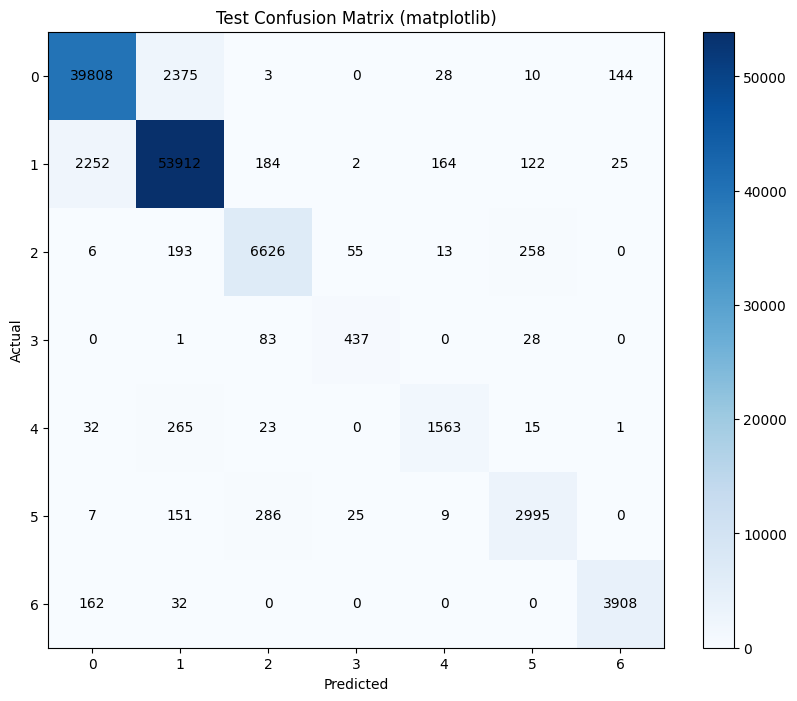


Test confusion matrix actual values:
[[39808  2375     3     0    28    10   144]
 [ 2252 53912   184     2   164   122    25]
 [    6   193  6626    55    13   258     0]
 [    0     1    83   437     0    28     0]
 [   32   265    23     0  1563    15     1]
 [    7   151   286    25     9  2995     0]
 [  162    32     0     0     0     0  3908]]


In [25]:
# decision tree with CV + hold-out evaluation (sampled train set for speed)
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, cross_val_predict, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Split dataset first ---
X_full = df_tree.drop(columns=['Cover_Type'])
y_full = df_tree['Cover_Type']

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# --- 2. Sample from train set for feasibility (stratified) ---
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train,
    train_size=60000,
    stratify=y_train,
    random_state=42
)

print(f"=== DEBUGGING INFO ===")
print(f"Original dataset size: {len(X_full)}")
print(f"Train set size: {len(X_train)}")
print(f"Train sample size: {len(X_train_sample)}")
print(f"Test set size: {len(X_test)}")

# --- 3. Hyperparameter tuning with CV on sampled train set ---
tune_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    param_grid=param_grid,
    cv=tune_cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1  # Reduced verbosity
)

grid_search.fit(X_train_sample, y_train_sample)
print("Best Params:", grid_search.best_params_)

# Mean ± std CV accuracy on train sample
cv_scores = cross_val_score(
    grid_search.best_estimator_, X_train_sample, y_train_sample,
    cv=tune_cv, scoring='accuracy', n_jobs=-1
)
print(f"Tuned Accuracy (5-fold CV on train sample): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# --- 4. CV predictions for F1 + classification report (on sample) ---
best_dt = grid_search.best_estimator_  # Fixed variable name
y_pred_cv = cross_val_predict(best_dt, X_train_sample, y_train_sample, cv=tune_cv, n_jobs=-1)

print("\nClassification Report (5-fold CV on train sample):")
print(classification_report(y_train_sample, y_pred_cv))

macro_f1 = f1_score(y_train_sample, y_pred_cv, average='macro')
weighted_f1 = f1_score(y_train_sample, y_pred_cv, average='weighted')
print(f"Macro F1 (CV): {macro_f1:.4f}")
print(f"Weighted F1 (CV): {weighted_f1:.4f}")

# --- 5. Train best model on full training set (not sample) ---
best_dt.fit(X_train, y_train)

# Training accuracy
train_preds = best_dt.predict(X_train)
training_accuracy = (train_preds == y_train).mean()
print(f"\nTraining Accuracy (80% train): {training_accuracy:.4f}")

# --- 6. Evaluate on hold-out test set (20%) ---
test_preds = best_dt.predict(X_test)
test_accuracy = (test_preds == y_test).mean()
print(f"Test Accuracy (20% test): {test_accuracy:.4f}")

# === DEBUGGING CONFUSION MATRIX ===
print(f"\n=== CONFUSION MATRIX DEBUGGING ===")

# Debug CV predictions
print(f"y_train_sample shape: {y_train_sample.shape}")
print(f"y_pred_cv shape: {y_pred_cv.shape}")
print(f"y_train_sample unique: {sorted(y_train_sample.unique())}")
print(f"y_pred_cv unique: {sorted(np.unique(y_pred_cv))}")

# Debug test predictions  
print(f"y_test shape: {y_test.shape}")
print(f"test_preds shape: {test_preds.shape}")
print(f"y_test unique: {sorted(y_test.unique())}")
print(f"test_preds unique: {sorted(np.unique(test_preds))}")

# Create multiple confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. CV predictions (sample)
cm_cv = confusion_matrix(y_train_sample, y_pred_cv)
print(f"CV confusion matrix shape: {cm_cv.shape}")
print(f"CV confusion matrix sum: {cm_cv.sum()}")

sns.heatmap(cm_cv, annot=False, cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('CV Predictions (Train Sample)')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# 2. Test set predictions
cm_test = confusion_matrix(y_test, test_preds)
print(f"Test confusion matrix shape: {cm_test.shape}")
print(f"Test confusion matrix sum: {cm_test.sum()}")

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[0,1])
axes[0,1].set_title('Test Set Predictions')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')

# 3. Training set predictions
cm_train = confusion_matrix(y_train, train_preds)
print(f"Train confusion matrix shape: {cm_train.shape}")
print(f"Train confusion matrix sum: {cm_train.sum()}")

sns.heatmap(cm_train, annot=False, cmap='Oranges', ax=axes[1,0])
axes[1,0].set_title('Training Set Predictions (Full)')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Actual')

# 4. Normalized test confusion matrix
cm_test_norm = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_test_norm, annot=True, fmt='.2f', cmap='Purples', ax=axes[1,1])
axes[1,1].set_title('Test Set (Normalized)')
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Try a simple matplotlib version if seaborn fails
print("\n=== TRYING SIMPLE MATPLOTLIB ===")
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Test Confusion Matrix (matplotlib)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
# Add text annotations
for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        plt.text(j, i, str(cm_test[i, j]), ha='center', va='center')
plt.show()

print(f"\nTest confusion matrix actual values:")
print(cm_test)